In [1]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, lfilter, freqz, hilbert
import peakutils
import pandas as pd

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reproducing-Fitzpatrick-et-al-2001" data-toc-modified-id="Reproducing-Fitzpatrick-et-al-2001-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reproducing Fitzpatrick et al 2001</a></span><ul class="toc-item"><li><span><a href="#Loading-the-data" data-toc-modified-id="Loading-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading the data</a></span></li></ul></li><li><span><a href="#Processing" data-toc-modified-id="Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Processing</a></span><ul class="toc-item"><li><span><a href="#Doing-the-subsetting-of-the-data" data-toc-modified-id="Doing-the-subsetting-of-the-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Doing the subsetting of the data</a></span></li><li><span><a href="#Visualizing-the-processing-steps" data-toc-modified-id="Visualizing-the-processing-steps-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Visualizing the processing steps</a></span></li></ul></li><li><span><a href="#Evaluating" data-toc-modified-id="Evaluating-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluating</a></span><ul class="toc-item"><li><span><a href="#Testing-on-the-same-records-as-the-paper" data-toc-modified-id="Testing-on-the-same-records-as-the-paper-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Testing on the same records as the paper</a></span></li><li><span><a href="#Testing-on-the-entire-MIT-BIH-database" data-toc-modified-id="Testing-on-the-entire-MIT-BIH-database-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Testing on the entire MIT-BIH database</a></span></li></ul></li></ul></div>

# Reproducing Fitzpatrick et al 2001
The aim of this notebook is to reproduce the QRS detection algorithm described in _"The use of the Hilbert transform in ECG signal analysis"_ by D. Benitez, P. A. Gaydeckia, A. Zaidi, A.P. Fitzpatrick.

## Loading the data

In [2]:
record = wfdb.rdsamp('mitdb/100', sampto=8050)
annotation = wfdb.rdann('mitdb/100', 'atr', sampto=8050)
record

(array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.475, -0.45 ],
        [-0.48 , -0.465],
        [-0.485, -0.475]]),
 {'fs': 360,
  'sig_len': 8050,
  'n_sig': 2,
  'base_date': None,
  'base_time': None,
  'units': ['mV', 'mV'],
  'sig_name': ['MLII', 'V5'],
  'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']})

In [3]:
lead_I = record[0][:, 0]
fs = record[1]['fs']

# Processing

In [4]:
def process_ecg(data, threshold=0.15):
    transformed = np.abs(hilbert(np.gradient(data)))
    return peakutils.indexes(transformed, thres=0.1,  min_dist=100)

def calculate_metrics(pred, test):
    # Counting the number of hits and misses. 
    # This needs to be developed more rigorous development
    fp, fn = 0, 0
    for p in pred:
        if np.sum(np.abs(p-test)<150)==0:
            fp += 1
    
    for t in test:
        if np.sum(np.abs(t-pred)<150)==0:
            fn += 1
    return fp, fn

In [5]:
def split_into_subsets(data):
    subset_len = 1024
    return splits

In [6]:
def set_threshols_for_subset(subset):
    h = np.abs(hilbert(np.gradient(subset)))
    h = h/np.max(h)
    max_amp = np.max(h)
    rms = np.sqrt(np.mean(np.square(h)))
    if rms>=0.18*max_amp:
        threshold = 0.39*max_amp
    else:
        threshold = 1.6*rms
    
    return threshold, process_ecg(h, threshold=threshold)

## Doing the subsetting of the data
In the paper they state that they subset the dataset into groups of 1024 points, because this should improve the performance of the Hilbert Transform.

In [7]:
subset = lead_I[:1025]
threshold, indxes = set_threshols_for_subset(subset)
print(threshold, indxes)

0.2502921983859773 [ 80 374 484 666 951]


In [8]:
indxes

array([ 80, 374, 484, 666, 951])

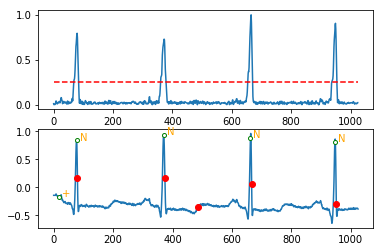

In [9]:
h = np.abs(hilbert(np.gradient(subset)))
h = h/np.max(h)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(h)
ax[0].plot([0, 1025], [threshold, threshold], '--r')
ax[1].plot(np.arange(0, 1025), subset)

for pos, sym in zip(annotation.sample, annotation.symbol):
    if pos>len(h):
        break
    else:
        ax[1].plot(pos, lead_I[pos], 'go', markersize=4, markerfacecolor='white')
        ax[1].text(pos+10, lead_I[pos], sym, color='orange')
        
ax[1].plot(indxes, subset[indxes], 'or')

## Visualizing the processing steps

/Users/hartmann/Documents/projects/ecg-analysis-mit-bih/env/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


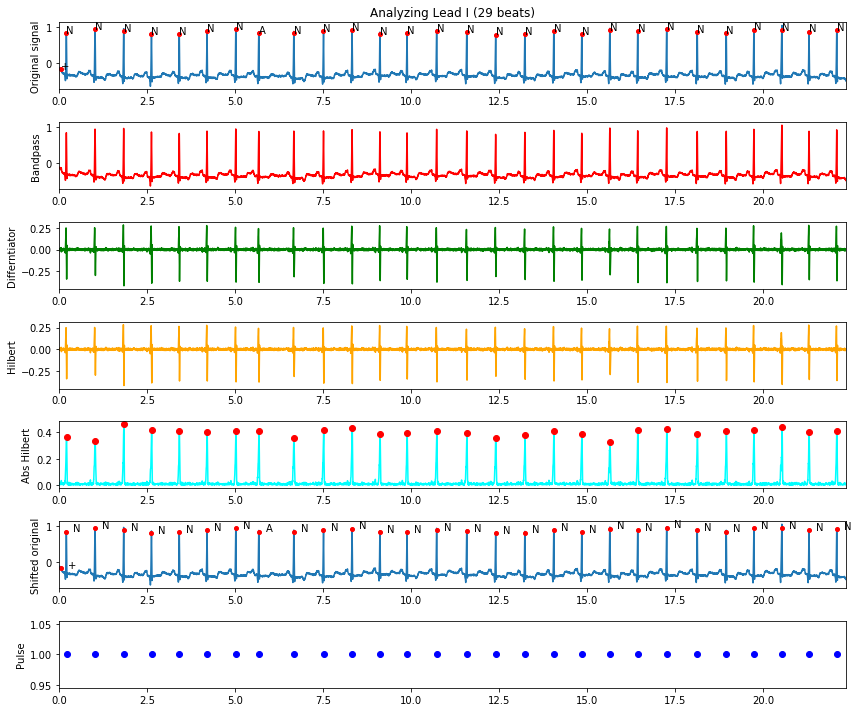

In [10]:
time = np.arange(0, len(lead_I))/fs

# The bandpass is different from the one used in the paper, and  
# generally does not produce the wished results.
bandpass =  lead_I #butter_bandpass_filter(lead_I, 6, 14, 360, order=6)

differentiator = np.gradient(bandpass)
hil = hilbert(differentiator)
abs_hil = np.abs(hil)

# Currently I am using the peakutils here, this should be replaced
pulse = peakutils.indexes(abs_hil, thres=0.1,  min_dist=100)

fig, ax = plt.subplots(nrows=7, figsize=(12,10))
ax[0].plot(time, lead_I)
ax[1].plot(time, bandpass, 'r')
ax[2].plot(time, differentiator, 'green')
ax[3].plot(time, hil, 'orange')
ax[4].plot(time, abs_hil, 'cyan');
ax[4].plot(time[pulse], abs_hil[pulse], 'or')
ax[5].plot(time, lead_I)
ax[6].plot(time[pulse], np.arange(len(pulse))*0+1, 'ob')

ax[0].set_ylabel('Original signal')
ax[1].set_ylabel('Bandpass')
ax[2].set_ylabel('Differntiator')
ax[3].set_ylabel('Hilbert')
ax[4].set_ylabel('Abs Hilbert')
ax[5].set_ylabel('Shifted original')
ax[6].set_ylabel('Pulse')

for x in ax:
    x.set_xlim([0, time[-1]])

for pos, sym in zip(annotation.sample, annotation.symbol):
    ax[0].plot(time[pos], lead_I[pos], 'ro', markersize=4)
    ax[0].text(time[pos], lead_I[pos], sym)

    
for pos, sym in zip(annotation.sample, annotation.symbol):
    ax[5].plot(time[pos], lead_I[pos], 'ro', markersize=4)
    ax[5].text(time[pos]+0.2, lead_I[pos], sym)
    
ax[0].set_title('Analyzing Lead I ({0:} beats)'.format(len(annotation.sample)))
fig.tight_layout()

# Evaluating
In the paper they do not evaluate the performance on the entire MIT-BIH database, so I will do the same.

## Testing on the same records as the paper

In [11]:
recnums = ['100', '101', '102', '103', '104', '105', '106', '107',
           '109', '111', '112', '113', '114', '115', '116', '117', '118',
           '119', '121', '122', '123', '124']
data = np.zeros( (len(recnums), 6) )
for idx, recno in enumerate(recnums):
    entire_sample = wfdb.rdsamp('mitdb/'+str(recno)) 
    entire_sample_anon = wfdb.rdann('mitdb/'+str(recno), 'atr')
    
    total_beats = np.sum([(sym!='+')&(sym!='~')&(sym!='"') for sym in entire_sample_anon.symbol])
    test = entire_sample_anon.sample
    
    dat = entire_sample[0][:, 0]
    pred = process_ecg(dat, threshold=0.01)
    
    fp, fn = calculate_metrics(pred, test)
    
    # Adding the results to the data matrix
    data[idx, :] = np.array([recno, total_beats, fp, fn, fp+fn, 100*(fp+fn)/total_beats])

In [12]:
results = pd.DataFrame(
    data=data,
    columns=['tape', 'total_beats', 'FP', 'FN', 'failed_detection_beats', 'failed_detection_percent']
)
results.head(48)

,tape,total_beats,FP,FN,failed_detection_beats,failed_detection_percent
0,100.0,2273.0,0.0,0.0,0.0,0.000000
1,101.0,1869.0,7.0,0.0,7.0,0.374532
2,102.0,2187.0,0.0,1.0,1.0,0.045725
3,103.0,2084.0,0.0,3.0,3.0,0.143954
4,104.0,2229.0,3.0,3.0,6.0,0.269179
5,105.0,2602.0,6.0,0.0,6.0,0.230592
6,106.0,2027.0,30.0,30.0,60.0,2.960039
7,107.0,2137.0,17.0,0.0,17.0,0.795508
8,109.0,2532.0,0.0,0.0,0.0,0.000000
9,111.0,2124.0,2.0,2.0,4.0,0.188324


In [13]:
print('Beats: {0:.0f}, FP: {1:.0f}, FN: {2:.0f}, Failed detections: {3:.0f} ({4:.2f}‰)'.format(
            results.total_beats.sum(),
            results.FP.sum(),
            results.FN.sum(),
            results.failed_detection_beats.sum(),
            results.failed_detection_percent.mean()
        )
     )

Beats: 45937, FP: 110, FN: 105, Failed detections: 215 (0.48‰)


In [14]:
print('Overall detection error percent: {0:.2f}%'.format(results.failed_detection_beats.sum()/results.total_beats.sum()*100))

Overall detection error percent: 0.47%


## Testing on the entire MIT-BIH database

In [15]:
def get_record_list():
    filenames = []
    all_files = [files for (path, dirs, files) in os.walk('mitdb')][0]
    for file in all_files:
        if file.endswith(".dat"):
            filenames.append(file[:3])
    return filenames

In [16]:
recnums = get_record_list()
data = np.zeros( (len(recnums), 6) )
for idx, recno in enumerate(recnums):
    entire_sample = wfdb.rdsamp('mitdb/'+str(recno)) 
    entire_sample_anon = wfdb.rdann('mitdb/'+str(recno), 'atr')
    
    total_beats = np.sum([(sym!='+')&(sym!='~')&(sym!='"') for sym in entire_sample_anon.symbol])
    test = entire_sample_anon.sample
    
    dat = entire_sample[0][:, 0]
    pred = process_ecg(dat, threshold=0.01)
    
    fp, fn = calculate_metrics(pred, test)
    
    # Adding the results to the data matrix
    data[idx, :] = np.array([recno, total_beats, fp, fn, fp+fn, 100*(fp+fn)/total_beats])

In [17]:
results = pd.DataFrame(
    data=data,
    columns=['tape', 'total_beats', 'FP', 'FN', 'failed_detection_beats', 'failed_detection_percent']
)
results.head(48)

,tape,total_beats,FP,FN,failed_detection_beats,failed_detection_percent
0,213.0,3251.0,0.0,0.0,0.0,0.000000
1,207.0,2346.0,5.0,146.0,151.0,6.436488
2,212.0,2749.0,0.0,0.0,0.0,0.000000
3,210.0,2651.0,0.0,2.0,2.0,0.075443
4,205.0,2657.0,0.0,1.0,1.0,0.037636
5,201.0,2000.0,1.0,20.0,21.0,1.050000
6,215.0,3363.0,0.0,0.0,0.0,0.000000
7,214.0,2267.0,5.0,12.0,17.0,0.749890
8,200.0,2601.0,25.0,26.0,51.0,1.960784
9,228.0,2077.0,66.0,26.0,92.0,4.429466


In [18]:
print('Beats: {0:.0f}, FP: {1:.0f}, FN: {2:.0f}, Failed detections: {3:.0f} ({4:.2f}‰)'.format(
            results.total_beats.sum(),
            results.FP.sum(),
            results.FN.sum(),
            results.failed_detection_beats.sum(),
            results.failed_detection_percent.mean()
        )
     )

Beats: 110303, FP: 600, FN: 876, Failed detections: 1476 (1.63‰)


In [19]:
print('Overall detection error percent: {0:.2f}%'.format(results.failed_detection_beats.sum()/results.total_beats.sum()*100))

Overall detection error percent: 1.34%
